In [61]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib import RcParams
import mpl_finance as finance
import matplotlib.ticker as ticker
import matplotlib.dates as dates
import seaborn as sns
import pandas_datareader as web
from sklearn.metrics import mean_squared_error as mse
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

# Outline

* Exploratory data analysis (EDA)
* Set up features (high-low, high-Close(previous), low-Close(previous))
* Set up MAC/D signaling
* calculate true range(TR) and average true range (ATR)
* set up volatility index from previous historical values
* Look into GARCH modeling for volatility
* Compounded annual percent returns
* log return for GARCH modeling

### TR and ATR

__TR__: max value between 3 methods

_Method 1: Current High minus the current Low_

_Method 2: Current High minus the previous Close (absolute value)_

_Method 3: Current Low minus the previous Close (absolute value)_

__ATR__: Calculated based on 14 periods. For stock data, weekends are not included so 14 periods is roughly 3 weeks of data.

$$Current ATR = [(ATR_P) * 13) + ATR_C] / 14$$

Where the P is prior and C is current in the ATR variables.

ATR requires a good deal of data to deliver valuable insight, so if we have little daily data, then our volatility index might be affected.

### Support and Resistance Lines

For a given period, such as one trading year, one can find a window in which a stock's price may generally fall into. Given the year, the max price of the stock is marked as the resistance line while the lowest price it's been is marked as the support line. The idea is that the stock will generally fall within this range for normal situations. If the price of the stock gets close to the support line, this is a good buy signal. When the price of the stock gets towards the resistance line or goes higher, its a sign that the market is in for a reversal and it may be a good sell signal. Reversals can happen either in the uptrend or downtrend, it just depends which direction the stock was before the predicted reversal period. 

The advantage of this method is that it's very simple to calculate and can be very accurate in an intuitive sense. However, the disadvantage is that it's not very nuanced and if one places an algorithmic buy signal at the support line, the stock might pullback or go through a reversal near the support line but not at the actual level. Therefor, it's a good strategy to compliment this signal with other, more nuanced signals in one's trading strategy. 

# Data preparation

In [62]:
style.use('ggplot')
plt.rcParams['figure.figsize'] = (15,7) # Setting default params for figures
start = dt.datetime(2000, 1, 1)
end = dt.datetime(2019,3,12)
#%matplotlib inline

In [63]:
comp_list = pd.read_csv("companylist.csv", usecols=['Symbol', 'Name', 'MarketCap', 'Sector'])
comp_list.shape

(3434, 4)

In [64]:
comp_list.dropna(axis=0, inplace=True)

In [65]:
top_earners = comp_list[comp_list['MarketCap']>1e9]
top_earners.sort_values(by='MarketCap', axis=0, ascending=False).head(10)

,Symbol,Name,MarketCap,Sector
2077,MSFT,Microsoft Corporation,8.478560e+11,Technology
214,AAPL,Apple Inc.,8.153190e+11,Technology
136,GOOGL,Alphabet Inc.,7.994430e+11,Technology
152,AMZN,"Amazon.com, Inc.",7.961420e+11,Consumer Services
135,GOOG,Alphabet Inc.,7.941250e+11,Technology
1059,FB,"Facebook, Inc.",4.840370e+11,Technology
1624,INTC,Intel Corporation,2.360030e+11,Technology
663,CSCO,"Cisco Systems, Inc.",2.248120e+11,Technology
720,CMCSA,Comcast Corporation,1.728470e+11,Consumer Services
2456,PEP,"Pepsico, Inc.",1.618620e+11,Consumer Non-Durables


In [66]:
comp_list['Sector'].value_counts()

Health Care              743
Finance                  685
Technology               432
Consumer Services        357
Capital Goods            169
Consumer Non-Durables    117
Miscellaneous             95
Consumer Durables         85
Basic Industries          76
Energy                    67
Public Utilities          62
Transportation            59
Name: Sector, dtype: int64

In [67]:
def rearrange_cols(item): # This tomake the dataframes look a little bit nicer
    cols = item.columns.tolist()
    cols = cols[-2:] + cols[:-2]
    return item[cols]

In [68]:
tsla_df = web.DataReader('TSLA', 'yahoo', start, end)
tsla_df['name'] = 'Tesla, Inc.'
tsla_df['symbol'] = 'TSLA'
tsla_df = rearrange_cols(tsla_df)

cgnx_df = web.DataReader('CGNX', 'yahoo', start, end)
cgnx_df['name'] = 'Cognex Corporation'
cgnx_df['symbol'] = 'CGNX'
cgnx_df = rearrange_cols(cgnx_df)

lulu_df = web.DataReader('LULU', 'yahoo', start, end)
lulu_df['name'] = 'lululemon athletica inc.'
lulu_df['symbol'] = 'LULU'
lulu_df = rearrange_cols(lulu_df)

pep_df = web.DataReader('PEP', 'yahoo', start, end)
pep_df['name'] = 'Pepsico, Inc.'
pep_df['symbol'] = 'PEP'
pep_df = rearrange_cols(pep_df)

amzn_df = web.DataReader('AMZN', 'yahoo', start, end)
amzn_df['name'] = 'Amazon.com, Inc.'
amzn_df['symbol'] = 'AMZN'
amzn_df = rearrange_cols(amzn_df)

fox_df = web.DataReader('FOX', 'yahoo', start, end)
fox_df['name'] = 'Twenty-First Century Fox, Inc.'
fox_df['symbol'] = 'FOX'
fox_df = rearrange_cols(fox_df)

aapl_df = web.DataReader('AAPL', 'yahoo', start, end)
aapl_df['name'] = 'Apple Inc.'
aapl_df['symbol'] = 'AAPL'
aapl_df = rearrange_cols(aapl_df)

goog_df = web.DataReader('GOOG', 'yahoo', start, end)
goog_df['name'] = 'Alphabet Inc.'
goog_df['symbol'] = 'GOOG'
goog_df = rearrange_cols(goog_df)

msft_df = web.DataReader('MSFT', 'yahoo', start, end)
msft_df['name'] = 'Microsoft Corporation'
msft_df['symbol'] = 'MSFT'
msft_df = rearrange_cols(msft_df)

nvda_df = web.DataReader('NVDA', 'yahoo', start, end)
nvda_df['name'] = 'NVIDIA Corporation'
nvda_df['symbol'] = 'NVDA'
nvda_df = rearrange_cols(nvda_df)

dfs = [tsla_df, cgnx_df, lulu_df, pep_df, amzn_df, fox_df, aapl_df, goog_df, msft_df, nvda_df]

In [69]:
tsla_df.head(12)

,name,symbol,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,,,
2010-06-29,"Tesla, Inc.",TSLA,25.000000,17.540001,19.000000,23.889999,18766300,23.889999
2010-06-30,"Tesla, Inc.",TSLA,30.420000,23.299999,25.790001,23.830000,17187100,23.830000
2010-07-01,"Tesla, Inc.",TSLA,25.920000,20.270000,25.000000,21.959999,8218800,21.959999
2010-07-02,"Tesla, Inc.",TSLA,23.100000,18.709999,23.000000,19.200001,5139800,19.200001
2010-07-06,"Tesla, Inc.",TSLA,20.000000,15.830000,20.000000,16.110001,6866900,16.110001
2010-07-07,"Tesla, Inc.",TSLA,16.629999,14.980000,16.400000,15.800000,6921700,15.800000
2010-07-08,"Tesla, Inc.",TSLA,17.520000,15.570000,16.139999,17.459999,7711400,17.459999
2010-07-09,"Tesla, Inc.",TSLA,17.900000,16.549999,17.580000,17.400000,4050600,17.400000
2010-07-12,"Tesla, Inc.",TSLA,18.070000,17.000000,17.950001,17.049999,2202500,17.049999


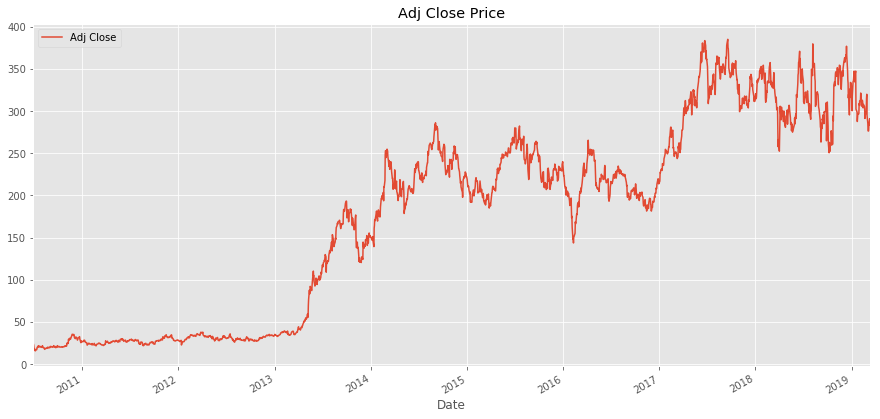

In [70]:
#Past trading years closing price
tsla_df['Adj Close'][:].plot(kind='line')
#tsla_df['Open'][-252:].plot()
plt.title('Adj Close Price')
plt.legend()
plt.show()

In [71]:
# Feature engineering
def set_spreads(df):
    for items in df:
        items['High-Low'] = items['High'] - items['Low']
        items['|H-Cp|'] = np.abs(items['High'] - items['Adj Close'].shift(1))
        items['|L-Cp|'] = np.abs(items['Low'] - items['Adj Close'].shift(1))
        items['Open-Close'] = items['Open'] - items['Adj Close']
        items['Open-High'] = items['Open'] - items['High'].shift(1)
        items['Open-Low'] = items['Open'] - items['Low'].shift(1)
        #items['gap_up'] = np.where(items['Open-High']>0, 1, 0)
        #items['gap_down'] = np.where(items['Open-Low']<0, 1, 0)
        items['TR'] = items[['High-Low', '|H-Cp|', '|L-Cp|']].max(axis=1)
        items['20_MA'] = items['Adj Close'].rolling(20, min_periods=0).mean() #The moving average for a usual monthly trading period
        items['20_EMA'] = items['Adj Close'].ewm(span=20, adjust=False).mean()
        items['50_EMA'] = items['Adj Close'].ewm(span=50, adjust=False).mean()
        items['5_MA'] = items['Adj Close'].rolling(5, min_periods=0).mean()
        items['50_MA'] = items['Adj Close'].rolling(100, min_periods=0).mean()
        items['ATR_5'] = np.divide(items['TR'].rolling(5, min_periods=0).sum(), 5) #Calculating moving average of TR for a standard trading week
        items['ATR_14'] = np.divide(items['TR'].rolling(14, min_periods=0).sum(), 14)
        #items['% ATR'] = np.divide(items['ATR'], items['Adj Close']) * 100
        items['Volatility %(Annualized)'] = items['Adj Close'].pct_change().rolling(14, min_periods=0).std(ddof=0)*(252**.5)*100
        items['Volatility %(Weekly)'] = items['Adj Close'].pct_change().rolling(14, min_periods=0).std(ddof=0)*(52**.5)*100
        items['Volatility %(Monthly)'] = items['Adj Close'].pct_change().rolling(14, min_periods=0).std(ddof=0)*(12**.5)*100
        items['Log_Returns'] = np.log(items['Adj Close']/items['Adj Close'].shift(1))
        
        
set_spreads(dfs)

In [12]:
tsla_df[['Open', 'Adj Close', 'High', 'Low', 'High-Low', '|H-Cp|', '|L-Cp|', 'TR', 'ATR_5', 'ATR_14']].head(12)

,Open,Adj Close,High,Low,High-Low,|H-Cp|,|L-Cp|,TR,ATR_5,ATR_14
Date,,,,,,,,,,
2010-06-29,19.000000,23.889999,25.000000,17.540001,7.459999,NaN,NaN,7.459999,1.492,0.532857
2010-06-30,25.790001,23.830000,30.420000,23.299999,7.120001,6.530001,0.590000,7.120001,2.916,1.041429
2010-07-01,25.000000,21.959999,25.920000,20.270000,5.650000,2.090000,3.559999,5.650000,4.046,1.445000
2010-07-02,23.000000,19.200001,23.100000,18.709999,4.390001,1.140001,3.250000,4.390001,4.924,1.758571
2010-07-06,20.000000,16.110001,20.000000,15.830000,4.170000,0.799999,3.370001,4.170000,5.758,2.056429
2010-07-07,16.400000,15.800000,16.629999,14.980000,1.650000,0.519999,1.130001,1.650000,4.596,2.174286
2010-07-08,16.139999,17.459999,17.520000,15.570000,1.950001,1.720000,0.230000,1.950001,3.562,2.313572
2010-07-09,17.580000,17.400000,17.900000,16.549999,1.350000,0.440001,0.910000,1.350000,2.702,2.410000
2010-07-12,17.950001,17.049999,18.070000,17.000000,1.070000,0.670000,0.400000,1.070000,2.038,2.486429


## Moving averages as trend indicators

A simple way to find trends in stocks is instead of looking at price day to day, we look at the averages price over a given interval of time. This is known as a moving average (MA). There are 2 main types of moving averages in technical analysis and each has its own advantages and disadvantages. 

There is the simple moving average (SMA) and the exponential moving average (EMA). The SMA is useful in that it provides a smooth trend curve that is easy to interpret and works well for long term trends. However, it's not very responsive to sharp changes in the market which may be caused by a reversal in the stock trend. 

The EMA is beneficial in that it's weighted by the most recent price so changes in stock price are more palpable in this measure. This makes it so that some data from the past which may be irrelevant is not considered as highly in finding the trend. The problem with this is that it can lead to very jagged trends and is prone to false signals/noise. 

The SMA is a good component to use if we have a longer time frame in mind such as with daily or weekly data. The EMA is more useful in an intraday trading strategy in which stock data is given every 15 minutes or some measure close ot that. In the context of this project, we are looking at long term trading and not necessarily day trading which is very risky and requires a good investment of time, therefor we will use the SMA. 

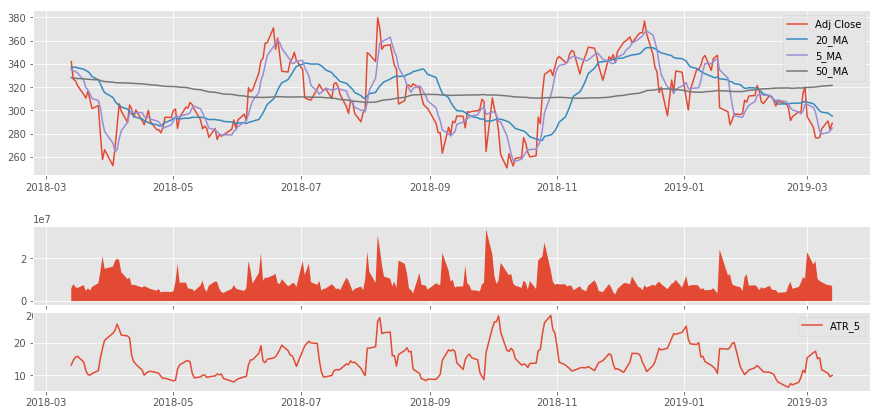

In [14]:
ax1 = plt.subplot2grid((9,1), loc=(0,0), rowspan=4, colspan=(1))
ax2 = plt.subplot2grid((9,1), loc=(5,0), rowspan=2, colspan=(1), sharex=ax1)
ax3 = plt.subplot2grid((9,1), loc=(7,0), rowspan=2, colspan=(1), sharex=ax1)
start = -252 #1 trading year
end = -1


ax1.plot(tsla_df.index[start:], tsla_df['Adj Close'][start:])
ax1.plot(tsla_df.index[start:], tsla_df['20_MA'][start:])
ax1.plot(tsla_df.index[start:], tsla_df['5_MA'][start:])
ax1.plot(tsla_df.index[start:], tsla_df['50_MA'][start:])
ax2.fill_between(tsla_df.index[start:], tsla_df['Volume'][start:], 0)
#ax2.ylabel('Volume')
ax3.plot(tsla_df.index[start:], tsla_df['ATR_5'][start:])
ax1.legend()
ax3.legend()
plt.show()

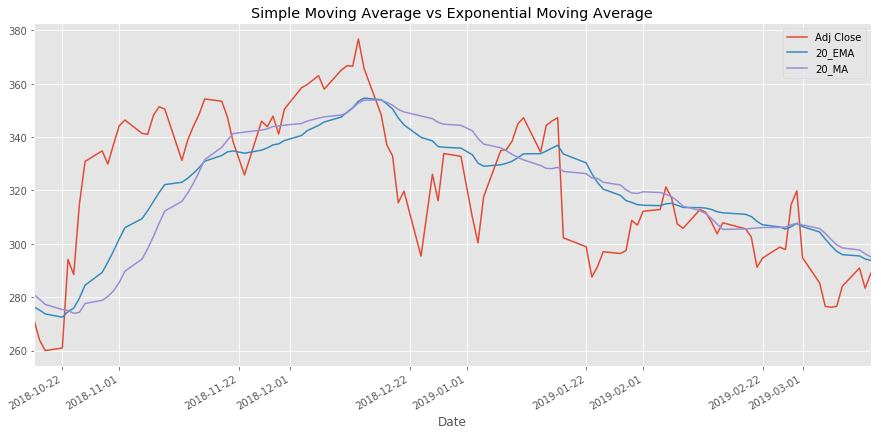

In [15]:
plot_obj = tsla_df[['Adj Close', '20_EMA', '20_MA']][-100:]
plot_obj.plot()
plt.title("Simple Moving Average vs Exponential Moving Average")
plt.show()

# Analyzing trends and which metrics to pick

In the above graph, we have mapped out the adjusted closing price of Tesla stock, 3 variations of of the rolling moving average (5 day, 21 day, 100 day), volume of stock being traded, and finally the rolling volatility with a window of 12 days. 

From the top graph, we see that the 100 day moving average is near useless for helping with any trend. The 21 day MA gets close, but seems to be lagging forward of the actual price trends. The 5 day MA gets the closest to the actual trend of the stock, making it a good candidate for further technical analysis. 

Another thing we see is that volume seems to correlate with volatility of the stock. Although not perfect, increases in volume seem to mark changes in stock price, whether that's up or down.
Finally, we analyze the annualized rolling volatility % change which was calculated with a window of 14 days. It also seems to have a slight trend associated with price of stock, although not as consistently as volume.

As for simple moving average (SMA) versus exponential moving average (EMA), we see that the exponential moving average swings closer to the adjusted close price and generally still has the same trend as the simlpe moving average. This shows that the EMA is more responsive to recent stock prices as opposed to the SMA. This can be very valuable in a relatively short trading period, but in cases where the trading period is very short such as one week, then the difference between the 2 values will be nearly identical. However, in windows that start increasing in range the EMA will be a better measure for short term trades as opposed to the SMA by a margin of a few dollars which is very important if one trades in a large number of stocks.  

# Interpreting a candlebar graph

Below is one of the most common tools used in technical analysis. It's the candlebar graph. This relatively simple graph conveys a great breadth of information including a particular stock's high, low, open, and close prices for a given time period. The flat ends of the bar part of the graph represent the open and close price. The line's coming out of the bars are indicators for the high and low price for that particular day. The addition of color changes how one reads the graphs.

The colors of the graph indicate direction of stock price for a given day. If a bar is green, then that means the stock was in an uptrend for the day and it closed higher than it opened for. With that in mind, the top line indicates the days price high and the bottom line indicates the days price low. The upper bart of the bar shows the close price and the lower part shows the days open price. 

When the bars are red, the major difference is that the indicators for the bars are switched. In red bars, the top part of the bar represents the open price and the bottom part represents the close price. The lines still hold their original meaning no matter the color. 

Now the color can be changed to any type we want but usually, downstrends are red and uptrends are either green or black. 

Armed with this knowledge, and with practice over time, one may graze over these graphs and gather a large amount of information and eventually form heuristics for price trends. 

In [61]:
tsla_df['Date'] = tsla_df.index.map(lambda x: dates.date2num(x))
tsla_df.head()

,name,symbol,High,Low,Open,Close,Volume,Adj Close,High-Low,|H-Cp|,...,Volatility %(Annualized),Volatility %(Weekly),Volatility %(Monthly),Log_Returns,Date,20_MA,Bollinger_upper,Bollinger_lower,Diff_1,20_EMA
Date,,,,,,,,,,,,,,,,,,,,,
2010-06-29,"Tesla, Inc.",TSLA,25.00,17.540001,19.000000,23.889999,18766300,23.889999,7.459999,NaN,...,NaN,NaN,NaN,NaN,733952.0,NaN,NaN,NaN,NaN,23.889999
2010-06-30,"Tesla, Inc.",TSLA,30.42,23.299999,25.790001,23.830000,17187100,23.830000,7.120001,6.530001,...,0.000000,0.000000,0.000000,-0.002515,733953.0,NaN,NaN,NaN,-0.059999,23.884285
2010-07-01,"Tesla, Inc.",TSLA,25.92,20.270000,25.000000,21.959999,8218800,21.959999,5.650000,2.090000,...,60.292222,27.388150,13.156842,-0.081723,733954.0,NaN,NaN,NaN,-1.870001,23.701020
2010-07-02,"Tesla, Inc.",TSLA,23.10,18.709999,23.000000,19.200001,5139800,19.200001,4.390001,1.140001,...,80.545860,36.588501,17.576548,-0.134312,733955.0,NaN,NaN,NaN,-2.759998,23.272351
2010-07-06,"Tesla, Inc.",TSLA,20.00,15.830000,20.000000,16.110001,6866900,16.110001,4.170000,0.799999,...,94.176344,42.780241,20.550963,-0.175470,733959.0,NaN,27.663933,14.332067,-3.090000,22.590223


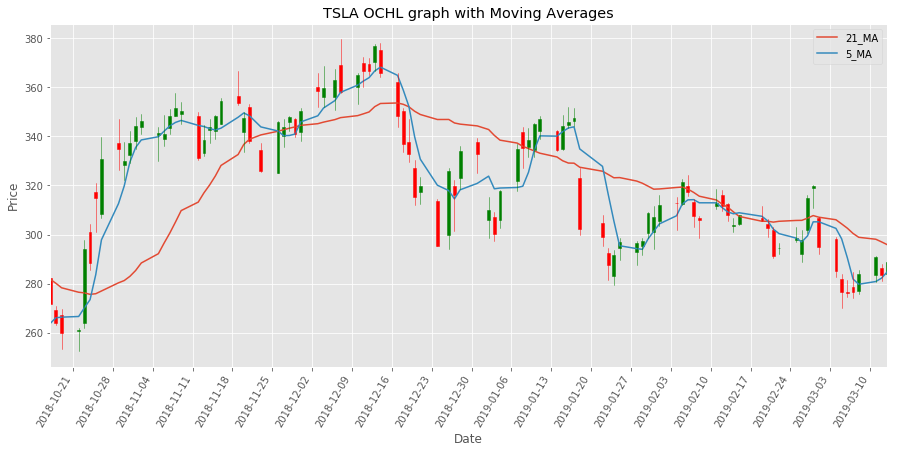

In [16]:
start=-100
fig, ax = plt.subplots()
tsla_df.iloc[start:, np.argmax(tsla_df.columns=='21_MA')].plot(ax=ax)
tsla_df.iloc[start:, np.argmax(tsla_df.columns=='5_MA')].plot(ax=ax)
finance.candlestick_ochl(ax,
                         quotes=tsla_df[['Date', 'Open', 'Close', 'High', 'Low']][start:].values,
                         width=.5,
                         colorup='green'
                         )
ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
plt.xticks(rotation=60)
plt.ylabel("Price")
plt.title("TSLA OCHL graph with Moving Averages")
plt.legend()
plt.show()

# Setting upper and lower limits for buy and sell signals

Bollinger bands are one of the tools used in technical analysis to assess risk in stock price based on volatility and was developed and made famous by a famous technical trader, John Bollinger. 

Volatility can be seen as a measure of how far a stock may move away from the mean. A stock entering a period of high volatility means that the moving average of the price for the stock/security/bond etc will divert away from that mean value greatly and low volatility means that the price swing will be more tight. 

Bollinger bands can be plotted as a central trend line for a stock calculated through a moving average and then has an upper and lower limit which is usually 1-2 standard deviations away from the average price. As mentioned earlier, high volatility is characterized by wider bands while lower volatility leads to the band contracting. Another general trend seen in stocks is periods of higher volatlity are usually followed by periods of low volatility and vice versa. Stocks don't follow a smooth normal trend but in fact operate in swings. However, this volatility spread is a double-edged sword. Higher volatility can be seen as a measure of risk in that the stock may either rise heavily or fall drastically. Hence the aspect of risk. This volatility measure does not tell us the direction of the swing, but rather shows us general trend guidelines that a stock may undergo. 

Given this tool, if we plot the bollinger bands for recent stocks and see that the bands are somewhat constricted compared to the past, we can expect a period of higher volatility approaching and can use this to set up entry and exit points for our strategy. One example could be to buy a stock and wait for it to go above 10% in profits then sell. The exit strategy could be to sell if the stock goes below 20% of the invested amount to stop any further losses and reassess from there. 

In [72]:
def set_bollinger_bands(df, window):
    df['{}_MA'.format(window)] = df['Adj Close'].rolling(window).mean()
    df['Bollinger_upper'] = df['{}_MA'.format(window)] + df['Adj Close'].rolling(window).std()*2
    df['Bollinger_lower'] = df['{}_MA'.format(window)] - df['Adj Close'].rolling(window).std()*2

In [73]:
for items in dfs:
    set_bollinger_bands(items, 20)

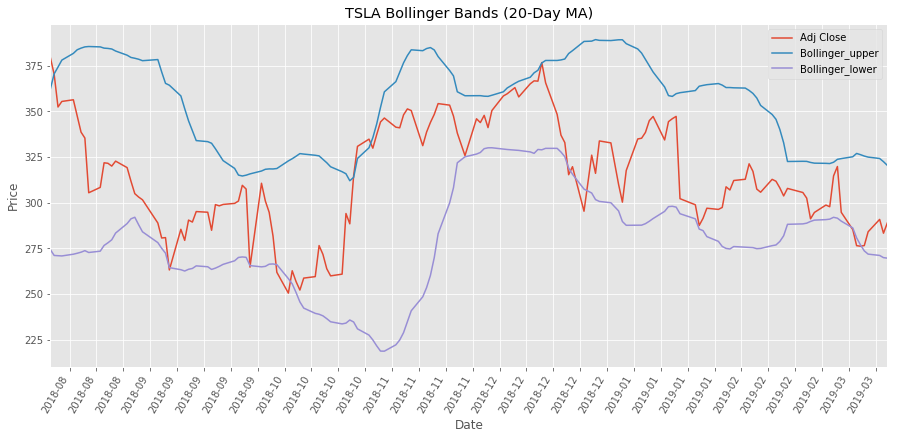

In [74]:
start=-150
fig, ax = plt.subplots()
tsla_df['Adj Close'][start:].plot(kind='line')
tsla_df['Bollinger_upper'][start:].plot(kind='line')
tsla_df['Bollinger_lower'][start:].plot(kind='line')
ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
plt.xticks(rotation=60)
plt.title("TSLA Bollinger Bands (20-Day MA)")
plt.ylabel('Price')
plt.legend()
plt.show()

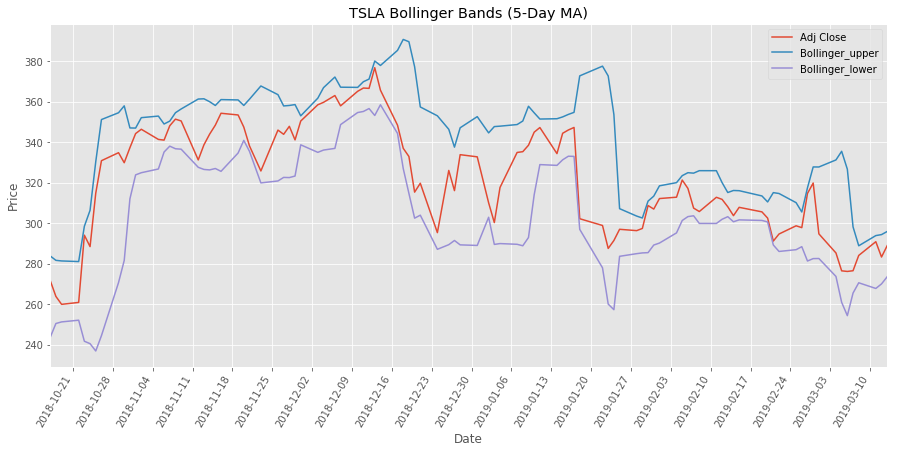

In [75]:
for items in dfs:
    set_bollinger_bands(items, 5)

fig, ax = plt.subplots()
start=-100
tsla_df['Adj Close'][start:].plot(kind='line')
tsla_df['Bollinger_upper'][start:].plot(kind='line')
tsla_df['Bollinger_lower'][start:].plot(kind='line')
plt.xticks(rotation=60)
ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
plt.title("TSLA Bollinger Bands (5-Day MA)")
plt.ylabel('Price')
plt.legend()
plt.show()

# Exit methodologies for different volatility measures

### MAC-D (Moving Average Convergence - Divergence)

Uses the difference between short terma nd long term price trends to anticipate movements. 

Calculated by subtracting 26 day Exponential Moving Average (EMA) from a 12 day EMA. Plot on graph afterwards

Plot a 9-day MA called the signal line. When the MAC line cross above the signal line, this should signal a bullish movement in which case the investor should buy.

### MA signal method

Create a buy/sell seignal when the fast MA line crosses the slow MA line, signaling that there might be a change in trend occuring. 

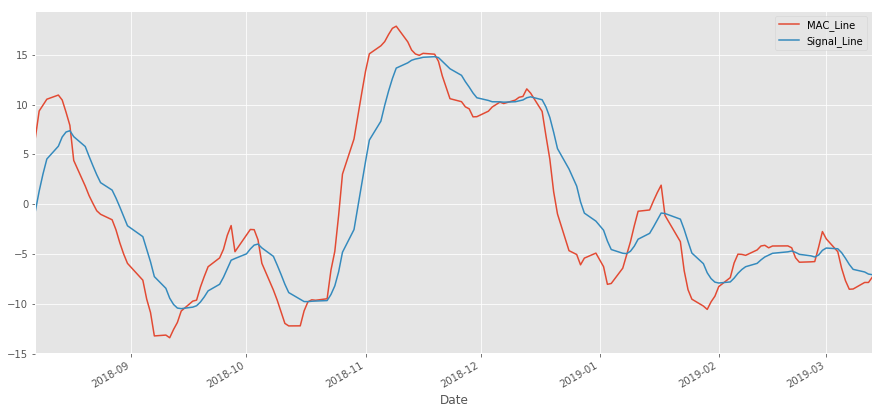

In [90]:
def mac_d(df):
    df['MAC_Line'] = df['Adj Close'].ewm(span=12, adjust=False).mean() - df['Adj Close'].ewm(span=26, adjust=False).mean()
    df['Signal_Line'] = df['MAC_Line'].ewm(span=9, adjust=False).mean()
    #df['MAC_buy'] = np.where()
    return df
tsla_df = mac_d(tsla_df)
tsla_df[['MAC_Line', 'Signal_Line']][-150:].plot()
plt.show()

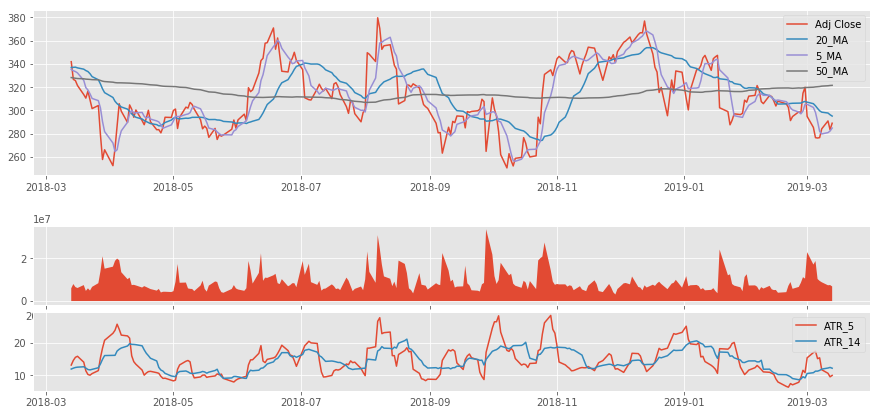

In [77]:
ax1 = plt.subplot2grid((9,1), loc=(0,0), rowspan=4, colspan=(1))
ax2 = plt.subplot2grid((9,1), loc=(5,0), rowspan=2, colspan=(1), sharex=ax1)
ax3 = plt.subplot2grid((9,1), loc=(7,0), rowspan=2, colspan=(1), sharex=ax1)
start = -252 #1 trading year
end = -1


ax1.plot(tsla_df.index[start:], tsla_df['Adj Close'][start:])
ax1.plot(tsla_df.index[start:], tsla_df['20_MA'][start:])
ax1.plot(tsla_df.index[start:], tsla_df['5_MA'][start:])
ax1.plot(tsla_df.index[start:], tsla_df['50_MA'][start:])
ax2.fill_between(tsla_df.index[start:], tsla_df['Volume'][start:], 0)
#ax2.ylabel('Volume')
ax3.plot(tsla_df.index[start:], tsla_df['ATR_5'][start:])
ax3.plot(tsla_df.index[start:], tsla_df['ATR_14'][start:])
ax1.legend()
ax3.legend()
plt.show()

In [91]:
def ATR_signals(df):
    df['ATR_entry'] = np.where(df['Adj Close'] > df['Adj Close'].shift()+df['ATR_14']*2, 1, 0)
    df['ATR_exit'] = np.where(df['Adj Close'] < df['Adj Close'].shift()-df['ATR_14']*2, 1, 0)
    return df
tsla_df = ATR_signals(tsla_df)

def chandelier_trailing_stop(df):
    max_buy = df['Adj Close'].rolling(50, min_periods=0).max()
    df['Chandelier_stop'] = .9
    return df
tsla_df = chandelier_trailing_stop(tsla_df)

In [92]:
tsla_df[['Adj Close', 'Chandelier_stop']].tail(20)

,Adj Close,Chandelier_stop
Date,,
2019-02-13,308.170013,312.578998
2019-02-14,303.769989,312.578998
2019-02-15,307.880005,312.578998
2019-02-19,305.640015,312.578998
2019-02-20,302.559998,289.215005
2019-02-21,291.230011,289.215005
2019-02-22,294.709991,289.215005
2019-02-25,298.769989,289.215005
2019-02-26,297.859985,289.215005


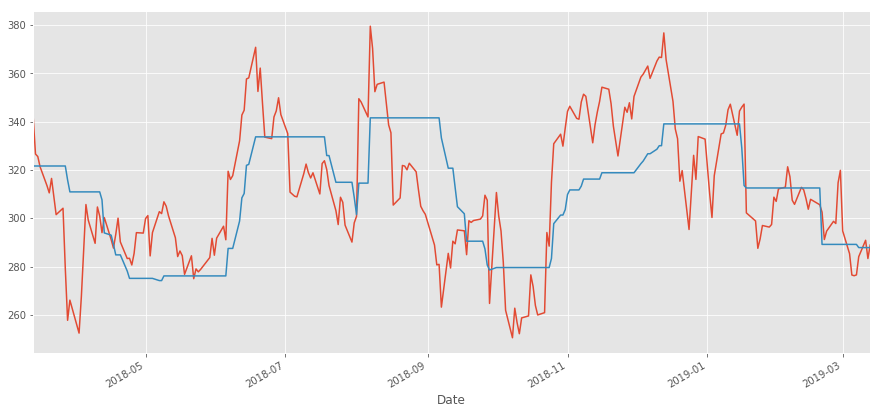

In [93]:
tsla_df.loc[:,'Adj Close'].iloc[-252:].plot()
tsla_df.loc[:, 'Chandelier_stop'].iloc[-252:].plot()

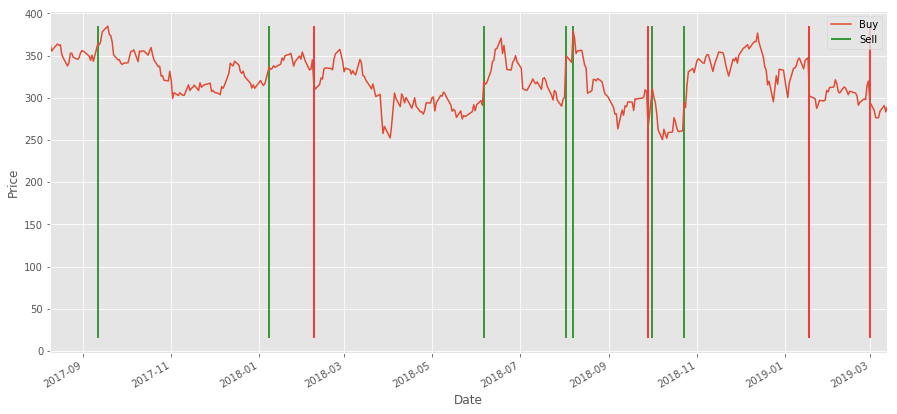

In [94]:
tsla_df.loc[:,'Adj Close'].iloc[-400:].plot()
plt.vlines(tsla_df.loc[tsla_df['ATR_entry']==1].iloc[:].index, 
           ymin=tsla_df['Adj Close'].min(), 
           ymax=tsla_df['Adj Close'].max(), 
           label='Buy',
           colors='g')
plt.vlines(tsla_df.loc[tsla_df['ATR_exit']==1].iloc[:].index, 
           ymin=tsla_df['Adj Close'].min(), 
           ymax=tsla_df['Adj Close'].max(), 
           label='Sell',
           colors='r')
plt.ylabel("Price")
plt.legend(['Buy', 'Sell'])
plt.show()

In [19]:
def create_regime(df):
    df["5d-50d"] = df['5_MA'] - df['50_MA']
    return df
create_regime(tsla_df)

,name,symbol,High,Low,Open,Close,Volume,Adj Close,High-Low,|H-Cp|,...,ATR_14,Volatility %(Annualized),Volatility %(Weekly),Volatility %(Monthly),Log_Returns,Bollinger_upper,Bollinger_lower,MAC_Line,Signal_Line,5d-50d
Date,,,,,,,,,,,,,,,,,,,,,
2010-06-29,"Tesla, Inc.",TSLA,25.000000,17.540001,19.000000,23.889999,18766300,23.889999,7.459999,NaN,...,0.532857,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,23.889999,0.000000
2010-06-30,"Tesla, Inc.",TSLA,30.420000,23.299999,25.790001,23.830000,17187100,23.830000,7.120001,6.530001,...,1.041429,0.000000,0.000000,0.000000,-0.002515,NaN,NaN,0.004786,23.860000,0.000000
2010-07-01,"Tesla, Inc.",TSLA,25.920000,20.270000,25.000000,21.959999,8218800,21.959999,5.650000,2.090000,...,1.445000,60.292222,27.388150,13.156842,-0.081723,NaN,NaN,0.157656,23.226666,0.000000
2010-07-02,"Tesla, Inc.",TSLA,23.100000,18.709999,23.000000,19.200001,5139800,19.200001,4.390001,1.140001,...,1.758571,80.545860,36.588501,17.576548,-0.134312,NaN,NaN,0.495799,22.220000,0.000000
2010-07-06,"Tesla, Inc.",TSLA,20.000000,15.830000,20.000000,16.110001,6866900,16.110001,4.170000,0.799999,...,2.056429,94.176344,42.780241,20.550963,-0.175470,NaN,NaN,1.001572,20.998000,0.000000
2010-07-07,"Tesla, Inc.",TSLA,16.629999,14.980000,16.400000,15.800000,6921700,15.800000,1.650000,0.519999,...,2.174286,96.041334,43.627425,20.957937,-0.019430,NaN,NaN,1.411148,20.131667,-0.751667
2010-07-08,"Tesla, Inc.",TSLA,17.520000,15.570000,16.139999,17.459999,7711400,17.459999,1.950001,1.720000,...,2.313572,139.051080,63.164893,30.343433,0.099903,NaN,NaN,1.583538,19.750000,-1.644000
2010-07-09,"Tesla, Inc.",TSLA,17.900000,16.549999,17.580000,17.400000,4050600,17.400000,1.350000,0.440001,...,2.410000,130.987277,59.501856,28.583767,-0.003442,NaN,NaN,1.705342,19.456250,-2.262250
2010-07-12,"Tesla, Inc.",TSLA,18.070000,17.000000,17.950001,17.049999,2202500,17.049999,1.070000,0.670000,...,2.486429,123.005174,55.875932,26.841929,-0.020320,NaN,NaN,1.809258,19.188889,-2.424889


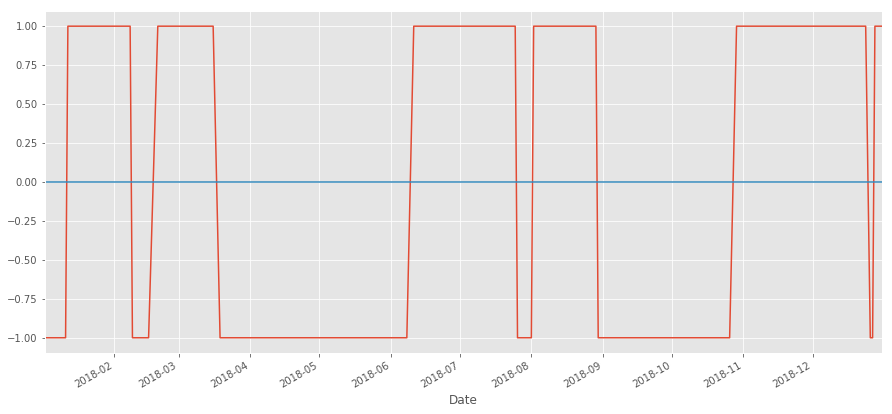

In [79]:
# If regime is positive, its bullish. If it's negative, then its bearish

tsla_df['Regime'] = np.where(tsla_df['5d-50d']>0, 1, 0)
tsla_df['Regime'] = np.where(tsla_df['5d-50d']<0, -1, tsla_df['Regime'])
tsla_df.loc['2018', 'Regime'].plot()
plt.plot([tsla_df.loc['2018'].index[0], tsla_df.loc['2018'].index[-1]], [0,0])

In [80]:
tsla_df['Regime'].value_counts()

 1    1294
-1     892
 0       5
Name: Regime, dtype: int64

In [83]:
tsla_df_origin = tsla_df.loc[:,'Regime'].iloc[-1]
tsla_df.loc[:,'Regime'].iloc[-1] = 0
tsla_df["Signal"] = np.sign(tsla_df["Regime"] - tsla_df["Regime"].shift(1))

C:\Users\sohai\Miniconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\sohai\Miniconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sign
  This is separate from the ipykernel package so we can avoid doing imports until


In [85]:
tsla_df[['Adj Close', 'Regime', 'Signal']].head(20)

,Adj Close,Regime,Signal
Date,,,
2010-06-29,23.889999,0,NaN
2010-06-30,23.830000,0,0.0
2010-07-01,21.959999,0,0.0
2010-07-02,19.200001,0,0.0
2010-07-06,16.110001,0,0.0
2010-07-07,15.800000,-1,-1.0
2010-07-08,17.459999,-1,0.0
2010-07-09,17.400000,-1,0.0
2010-07-12,17.049999,-1,0.0


In [86]:
tsla_df['Signal'].value_counts()

 0.0    2124
 1.0      33
-1.0      33
Name: Signal, dtype: int64

# Checking for stationary in data before  we start modeling

Other than visual inspection of our data as well as looking at descriptive statistics for our stocks to determine stationarity, we can rely on more stringent statistical tests to evaluate the degree to which our data is likely to be stationary or not.

Based on previous inspection of the TSLA stock, we can clearly see that there is a trend to the data. Seasonality does not seem be as apparent at the monthly or weekly level.

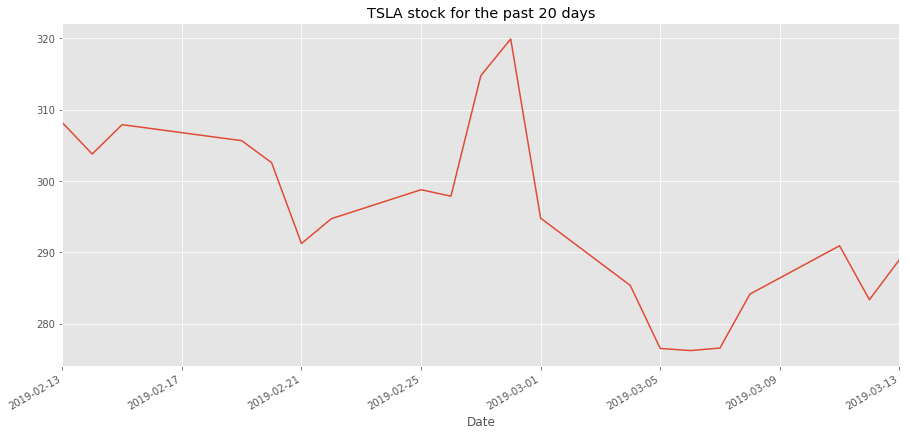

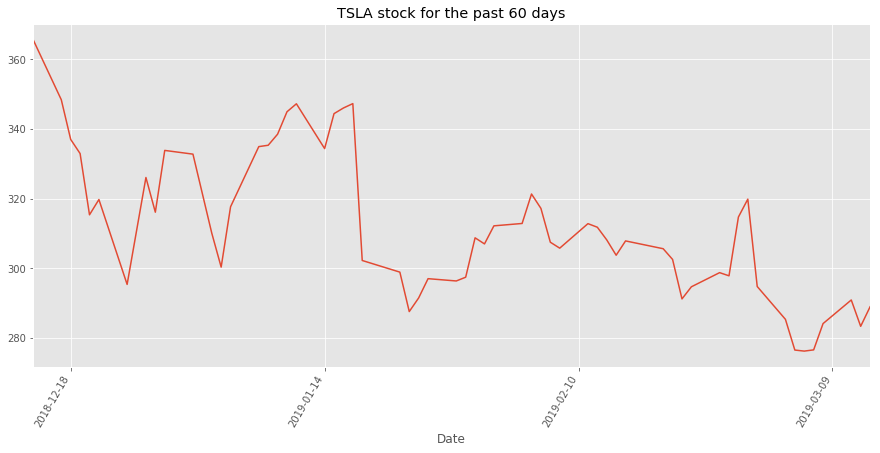

In [21]:
tsla_df['Adj Close'][-20:].plot()
plt.title("TSLA stock for the past 20 days")
plt.show()

fig, ax = plt.subplots()
tsla_df['Adj Close'][-60:].plot()
plt.title("TSLA stock for the past 60 days")
ax.xaxis.set_major_locator(ticker.MultipleLocator(27))
plt.xticks(rotation=60)
plt.show()

Visual inspection shows us that the regular stock close price is not stationary nor does it seem to have any trends in the recent months. From the graph of the full close price from earlier, there doesn't seem to be any seasonality either, but there is some trend in the positive since Tesla's onset. 

In [22]:
# Running statistical tests to check for stationarity
def check_stationarity(df, item):
    X = df[str(item)]
    result = adfuller(X)
    print('ADF Statistic: {:.3f}'.format(result[0]))
    print('p-value: {:.3f}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {:.3f}'.format(key, value))
    return
        
check_stationarity(tsla_df[252:], 'Adj Close')

ADF Statistic: -1.622
p-value: 0.472
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


The above result shows that our Tesla stock close price is likely to not be stationary as the p value for our result was above .05, therefor we cannot reject the null hypothesis that our data is not stationary.

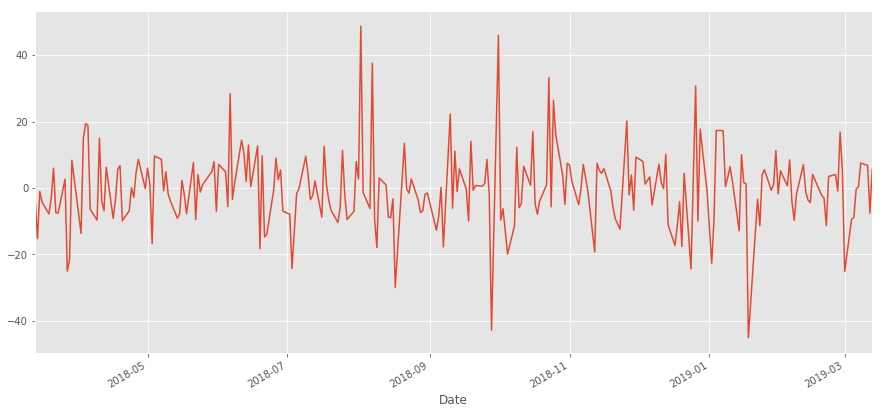

In [23]:
tsla_df['Diff_1'] = tsla_df['Adj Close'] - tsla_df['Adj Close'].shift(1)
tsla_df['Diff_1'][-252:].plot()
plt.show()

In [24]:
tsla_df[['Adj Close', 'Diff_1']].head()

,Adj Close,Diff_1
Date,,
2010-06-29,23.889999,NaN
2010-06-30,23.830000,-0.059999
2010-07-01,21.959999,-1.870001
2010-07-02,19.200001,-2.759998
2010-07-06,16.110001,-3.090000


In [25]:
check_stationarity(tsla_df[-252:], 'Diff_1')

# It seems like our differences data is stationary after all

ADF Statistic: -17.240
p-value: 0.000
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573


### Looking at autocorrelation and partial autocorrelation for the last trading year

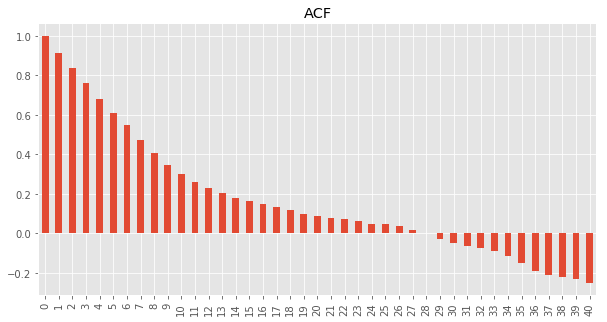

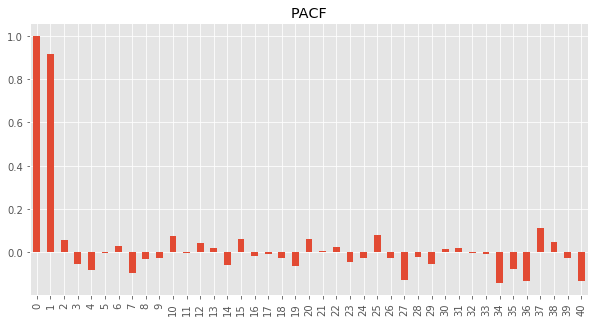

In [26]:
def run_autocorrelations(df, factor):
    x_acf = pd.Series(acf(df[factor]))
    x_acf.plot(kind='bar', figsize=(10,5))
    plt.title("ACF")
    plt.show()
    x_pacf = pd.Series(pacf(df[factor]))
    x_pacf.plot(kind='bar', figsize=(10,5))
    plt.title("PACF")
    plt.show()
    return

run_autocorrelations(tsla_df[-252:], 'Adj Close')

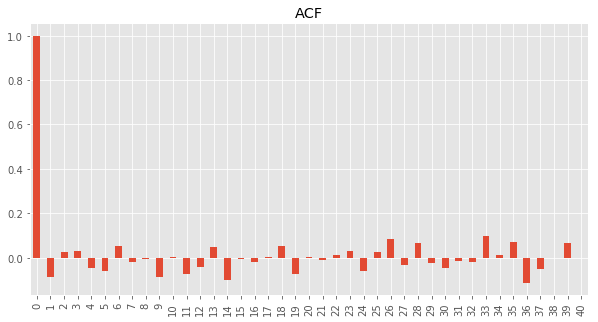

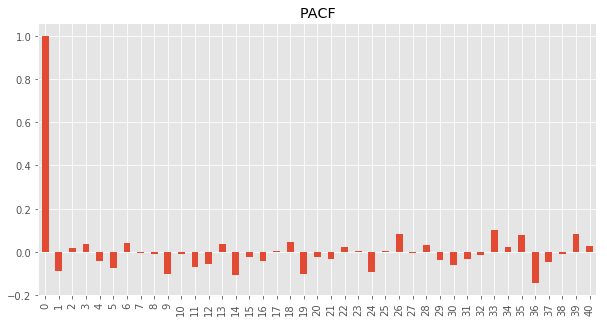

In [27]:
run_autocorrelations(tsla_df[-252:], 'Diff_1')

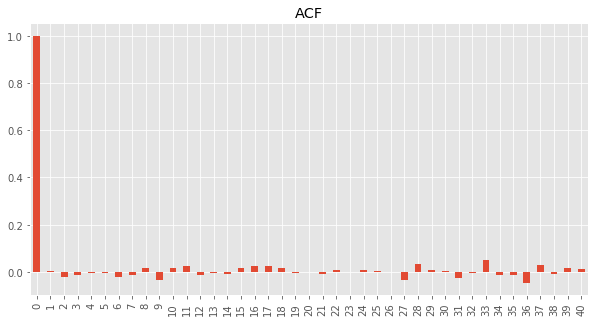

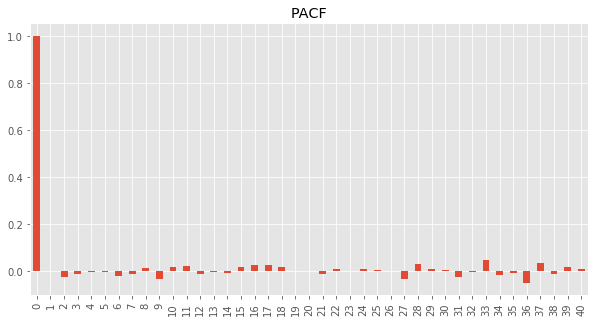

In [47]:
run_autocorrelations(tsla_df[1:], 'Log_Returns')

# Modeling volatility - ARCH

The ARCH or Autoregressive Conditional Heteroskedasticity method provides a way to model a change in variance in a time series that is time dependent, such as increasing or decreasing volatility. But before we get into the details for such modeling, we have to understand why we are using this method in the first place.

Autoregressive models have been developed to capture time series data that is stationary (AR), has a trend (ARIMA), and has a seasonal component as well (SARIMA). These models try to model the conditional mean of a stochastic process. The problem with these models is that they do not capture variance over a period of time. In some cases with modest variance in the time series data we could apply a log or box cox transformation to the stationary data in order to capture that effect, but that won't always be the case. Most of the time in real world data, we have different variances for the time series at various points in time. This refers to the heteorskedastic nature of the data. This is where ARCH models were developed to capture and model this uneven variance over time.

ARCH models try to model the variance in a time series at every time step as a function by looking at the residual errors from a mean process (such as 0 mean). ARCH models take a parameter called __q__ that is the lag order for the residual term. It refers to how far back in error terms it should look for modeling variance. Like ARMA models and its variants, the data is expected to be stationary. 

ARCH models should be used on top of ARMA models to capture both the conditional mean and variance of a stochastic process. 

In [35]:
def evaluate_arima(order, factor, df, split_size=.8):
    split = int(len(df)*split_size)
    train = df.iloc[:split]
    test = pd.DataFrame(df.iloc[split:, np.argmax(df.columns==factor)].reset_index())
    
    arima = ARIMA(train[factor], order=order)
    model_fit = arima.fit()
    pred = model_fit.predict(start=split, end=int(len(df))-1, typ= 'levels')
    error = mse(test[factor], pred)
    
    return [str(order), error]

def best_model_params(df, factor, limit=1, split_size=.8):
    best_mse, best_param=1e11, None
    for p in range(limit):
        for q in range(limit):
            try:
                result = evaluate_arima(order=[p,1,q], df=df, factor=factor, split_size=split_size)
            except:
                continue
            if result[1]<best_mse:
                best_mse=result[1]
                best_param = [p,1,q]
    return "{:.3f}".format(best_mse), best_param

In [39]:
len(tsla_df['Adj Close'][-252:-14])

238

In [44]:
arima = ARIMA(tsla_df['Adj Close'][-252:-14], order=[2,1,2])
model_fit = arima.fit()
pred = model_fit.predict(start=238, end=len(tsla_df[-252:]), typ= 'levels')

C:\Users\sohai\Miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\sohai\Miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\sohai\Miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\sohai\Miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [36]:
best_model_params(tsla_df[-252:], 'Adj Close', limit=5)

C:\Users\sohai\Miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\sohai\Miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\sohai\Miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\sohai\Miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users

C:\Users\sohai\Miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\sohai\Miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\sohai\Miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\sohai\Miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users

C:\Users\sohai\Miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\sohai\Miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\sohai\Miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\sohai\Miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users

('350.958', [0, 1, 0])

In [31]:
def run_arima(order, factor, df, split_size=.9):
    split = int(len(df)*split_size)
    train = df.iloc[:split, np.argmax(df.columns==factor)]
    test = pd.DataFrame(df.iloc[split:, np.argmax(df.columns==factor)].reset_index())
    print(train.head())
    for i in range(14):
        arima = ARIMA(train, order=order)
        model_fit = arima.fit()
        pred = model_fit.forecast()
        print(pred[0])
        train.append(pd.Series(pred[0]))
    test.plot(kind='line')
    train.plot()

run_arima([4,0,2], 'Diff_1', tsla_df[-252:])

C:\Users\sohai\Miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Date
2018-03-13    -3.670013
2018-03-14   -15.209991
2018-03-15    -1.029999
2018-03-16    -4.250000
2018-03-19    -7.790009
Name: Diff_1, dtype: float64
[-0.71009084]


C:\Users\sohai\Miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


[-0.71009084]


C:\Users\sohai\Miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


[-0.71009084]


C:\Users\sohai\Miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


[-0.71009084]


C:\Users\sohai\Miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


[-0.71009084]


C:\Users\sohai\Miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


[-0.71009084]


C:\Users\sohai\Miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


[-0.71009084]


C:\Users\sohai\Miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


[-0.71009084]


C:\Users\sohai\Miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


[-0.71009084]


C:\Users\sohai\Miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


[-0.71009084]


C:\Users\sohai\Miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


[-0.71009084]


C:\Users\sohai\Miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


[-0.71009084]


C:\Users\sohai\Miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


[-0.71009084]


C:\Users\sohai\Miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


[-0.71009084]


ValueError: view limit minimum -36882.89449615479 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x000001D7987E06A8> (for post_execute):


ValueError: view limit minimum -36882.89449615479 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

ValueError: view limit minimum -36882.89449615479 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 1080x504 with 1 Axes>